# Modified SIRD Model for Covid-19

In [1]:
import numpy as np
#from numpy import random
from covid import read_dataset,country,mod_sird
from covid.stat import stat_model
from IPython.display import display, Math
#from tqdm import tqdm,tqdm_notebook
import matplotlib.pyplot as plt

## Brasil

In [11]:
SingleParameterEstimates[:,1]

array([0.83604653, 0.26023154, 0.10074345, 0.01159491, 3.46812252])

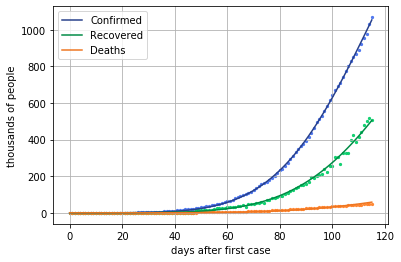

In [2]:
# Raw Estimated Parameters
scl_factor = 1000;
par_labels = ['α','β','r','d','logS0']
par_dim = len(par_labels)
par_est = np.array([0.8353,0.2605,0.1010,0.01165,3.472])
par_stp = [0.001,0.0001,0.0001,7.25e-05,0.2]

#df = read_dataset('Bing-COVID19-Data.csv')
df = read_dataset('https://raw.githubusercontent.com/microsoft/Bing-COVID-19-Data/master/data/Bing-COVID19-Data.csv',url=True)
brasil_df = country(name = "Brazil", population = 212000000)
brasil_df.dataset(df,rescaling_by=1/scl_factor)

StatModel = stat_model(brasil_df,mod_sird,par_est,rescaling_by=1/scl_factor,par_labels=par_labels)
StatModel.data_model_plot(par_est)

Notice that in the case of Brazil the recovered data are more scattered than confirmed and death cases. It need to think about a way to estimate errors to this data. As we don't have this yet,lets generate a MCMC sample, trying to fit just confirmed and deaths cases.

In [12]:
# generating a mcmc sample by metropolis-hastings algorithm
StatModel.metropolis_hastings(2000000,
                              par_stp,
                              overwrite=False,
                              file_name='brazil_mcmc_sample_5par.csv',
                              n_walkers=1,
                              fit_confirmed = True,
                              fit_death = True,
                              fit_recovered = True
                             )


walker 1: 100%|██████████| 2000000/2000000 [54:14<00:00, 614.45it/s] 


## Monte-Carlo Approach

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

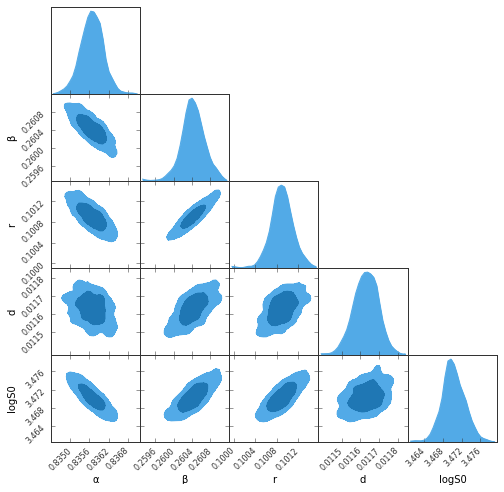

In [3]:
StatModel.import_sample(file_name='brazil_mcmc_sample_5par.csv')
SingleParameterEstimates = StatModel.single_parameter_estimates(alpha=0.3173)

for i in range(par_dim):
    mcmc = SingleParameterEstimates[i]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], par_labels[i])
    display(Math(txt))

GTCPlot = StatModel.gtc_plot(save_figure=True)

## Confidence Regions in Epidemiologic Curves

100%|██████████| 500/500 [00:07<00:00, 69.18it/s]


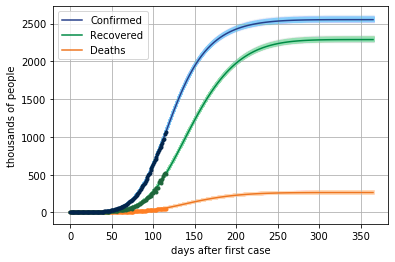

In [5]:
from tqdm import tqdm
from numpy import random


TEND = 365;
ALPHA = 0.02;
    
# Raw Estimated Parameters
par_est = SingleParameterEstimates[:,1]

# Solving Equations
x0 = [10**(par_est[-1]),1/scl_factor,0,0]


msird_av = mod_sird(par_est, x0,TEND)
msird_av.solve()

t = msird_av.days_list

# Confirmed Cases Plot
c_model = msird_av.confirmed_list
plt.plot(t,c_model,color='#27408B', label='Confirmed',zorder=10)
plt.scatter(brasil_df.days_list,brasil_df.confirmed_list, color='#03254c',s=9,zorder=13)


# Recovered Cases Plot
r_model = msird_av.recovered_list
plt.plot(t,r_model,color='#008B45', label='Recovered',zorder=10)
plt.scatter(brasil_df.days_list,brasil_df.recovered_list, color='#1e663b',alpha=1.,s=9,zorder=12)

# Death Cases Plot
d_model = msird_av.death_list
plt.plot(t,d_model,color='#EE7621', label='Deaths',zorder=10)
plt.scatter(brasil_df.days_list,brasil_df.death_list, color='#FF7F24',alpha=1.,s=9,zorder=11)


final_deaths = []
final_cases  = []

for index in tqdm(list(random.choice(range(len(StatModel.sample)),500))):
    
    par_rdn = StatModel.sample[index]
    

    # Solving Equations
    x0 = [10**(par_rdn[-1]),1/scl_factor,0,0]
    msird_av = mod_sird(par_rdn, x0,TEND)
    msird_av.solve()
    
    t = msird_av.days_list
    
    # Confirmed Cases Plot
    c_model = msird_av.confirmed_list
    plt.plot(t,c_model,color='#87CEFA',  alpha=ALPHA, linewidth=3)
    
    # Recovered Cases Plot
    r_model = msird_av.recovered_list
    plt.plot(t,r_model,color='#98e0b5',alpha=ALPHA, linewidth=3)
    
    # Death Cases Plot
    d_model = msird_av.death_list
    plt.plot(t,d_model,color='#FFDAB9', alpha=ALPHA, linewidth=3)
    
    final_cases.append(np.interp(TEND, t, c_model))
    final_deaths.append(np.interp(TEND, t, d_model))
    


plt.legend(loc="upper left")
plt.xlabel('days after first case')
plt.ylabel('thousands of people')
plt.grid()


plt.savefig('results/cases_projection.png')
#plt.savefig('tables/cases_projection.pdf')
plt.show()


## Estimates on Total Deaths ans Final Cases

100%|██████████| 50000/50000 [05:26<00:00, 153.15it/s]


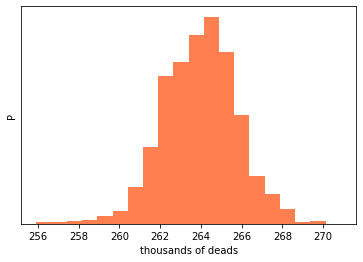

<IPython.core.display.Math object>

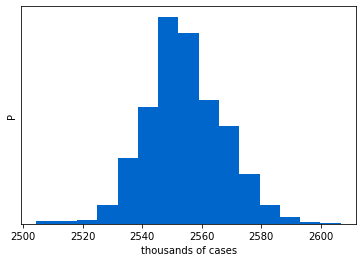

<IPython.core.display.Math object>

In [6]:
TEND = 365;
ALPHA = 0.07;


final_deaths = []
final_cases  = []

for index in tqdm(list(random.choice(range(len(StatModel.sample)),50000))):
    
    par_rdn = StatModel.sample[index]
    

    # Solving Equations
    x0 = [10**(par_rdn[-1]),1/scl_factor,0,0]
    msird_av = mod_sird(par_rdn, x0,TEND)
    msird_av.solve()
    
    t = msird_av.days_list
    
    # Confirmed Cases Plot
    c_model = msird_av.confirmed_list
    
    # Recovered Cases Plot
    r_model = msird_av.recovered_list
    
    # Death Cases Plot
    d_model = msird_av.death_list
    
    final_cases.append(np.interp(TEND, t, c_model))
    final_deaths.append(np.interp(TEND, t, d_model))


    

deaths_sample = np.array(final_deaths)
plt.hist(deaths_sample,20, color="#FF7F50")
plt.xlabel('thousands of deads')
plt.ylabel('P')
plt.gca().set_yticks([]);
plt.savefig('results/deaths_hist.png')
plt.savefig('results/deaths_hist.pdf')
plt.show()

mcmc_d = np.percentile(deaths_sample, [15.865, 50, 84.135])
q_d = np.diff(mcmc_d)
txt_d = "\mathrm{{{3}}} : {0:.3f}_{{-{1:.5f}}}^{{{2:.5f}}}"
txt_d = txt_d.format(mcmc_d[1], q_d[0], q_d[1], 'Deaths')
display(Math(txt_d))


cases_sample = np.array(final_cases)
plt.hist(cases_sample,15, color="#0066CC")
plt.xlabel('thousands of cases')
plt.ylabel('P')
plt.gca().set_yticks([]);
plt.savefig('tables/cases_hist.png')
plt.savefig('tables/cases_hist.pdf')
plt.show()

mcmc_c = np.percentile(cases_sample, [15.865, 50, 84.135])
q_c = np.diff(mcmc_c)
txt_c = "\mathrm{{{3}}} : {0:.3f}_{{-{1:.5f}}}^{{{2:.5f}}}"
txt_c = txt_c.format(mcmc_c[1], q_c[0], q_c[1], 'Cases')
display(Math(txt_c))


In [17]:
type(brasil_df.days_list)

numpy.ndarray